# Métodos de residuos pesados


#### Manuel Jaramillo, Henry Fehrmann, Nicolás Treimún
#### Prof. Cristian Olivares
#### Software de ingeniería

In [1]:
import numpy as np
from sympy import *
from sympy.abc import x
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [2]:
y = Function('y')  # define a y como funcion dependiente
x = Symbol('x') # define a x como variable independiente

ecuacion_dif = Eq(diff(y(x), x, 4), - y(x) + 1) # define ecuacion diferencial
#display(ecuacion_dif)

In [3]:
condicion_borde={ y(x).diff(x).subs(x,0): 0, y(x).diff(x).subs(x,1): 0, y(0):0, y(1):0 }
solucion=dsolve(ecuacion_dif,y(x),ics=condicion_borde) # resuelve ecuacion diferencial
#display(solucion) 

## Gráfico de métodos

<IPython.core.display.Javascript object>


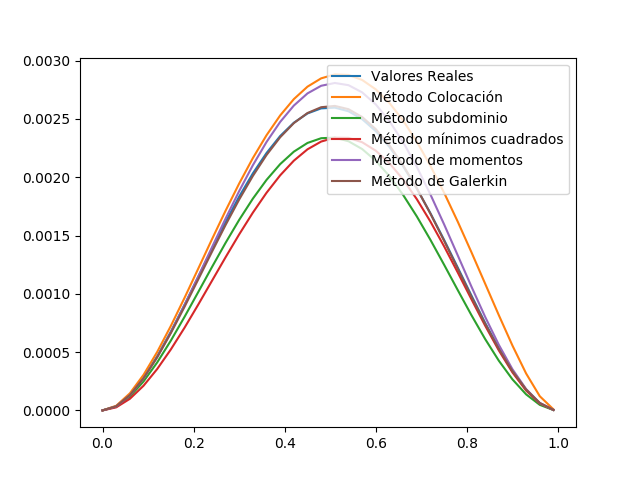

In [4]:
%matplotlib notebook 

transforma=lambdify(x,solucion.rhs) # transforma a valores numericos reales

rango=np.arange(0,1,0.03) #  rango del grafico
plt.plot(rango,transforma(rango), label="Valores Reales") # grafico
plt.legend(loc='upper right') # coloco valores totales  a la derecha arriba.

## Definición de función de aproximación

El problema sugiere tres $\varphi(x)$ 

$$
\hat u(x) = a_1 \varphi(x)_1  + a_2 \varphi(x)_2 + a_3 \varphi(x)_3 
$$

tal que se cumplan las **condiciones de borde**:

 - u = 0 y $\frac{du}{dx}=0 $ ; x = 1 ; x = 0
 
La función aproximación que utilizaremos será

$$
\hat u(x) =  x^2 (x-1)^2 e^{x}a_1 + x^3 (x-1)^2 e^{x^2}a_2 + x^4 (x-1)^2 e^{x^3}a_3
$$

$u(0)=0 ; u(1)=0$ ; 
$\frac{du}{dx}(0)=0 $ ; 
$\frac{du}{dx}(1)=0  $

La función residuo la obtendremos al reemplazar en la siguiente ecuación diferencial:

$$
 \frac{\partial^4 y}{\partial x^4} + y = 1
$$



## 1. Método de colocación

Para el método de colocación se necesita solamente la función residuo igualada a 0 la cual obtendremos reemplazando en la ecuación diferencial. Luego se reemplazará x por tres valores, en nuestro caso 0.2, 0.6 y 0.8 para así generar un sistema con 3 ecuaciones y 3 incognitas $a_1, a_2, a_3$


In [5]:
phi1 = (x**2) * ((x-1)**2) * (exp(x))
phi2 = (x**3) * ((x-1)**2) * (exp(x**2))
phi3 = (x**4) * ((x-1)**2) * (exp(x**3))

phis =[lambdify(x,phi1), lambdify(x,phi2), lambdify(x,phi3)]

phis_4deriv = [lambdify(x,diff(phi1,x,4)), lambdify(x,diff(phi2,x,4)), lambdify(x,diff(phi3,x,4)) ]
f_residuo = [lambda x: phis_4deriv[0](x)+phis[0](x), lambda x: phis_4deriv[1](x)+phis[1](x), lambda x: phis_4deriv[2](x)+phis[2](x), lambda x:-1]

In [6]:
xses = [0.2, 0.6, 0.8]
Matrix_col = np.zeros((3,3))
Vector_col = np.zeros(3)

In [7]:
for j in range(0,3):
    for i in range(0,3):
        #print(i,j)
        Matrix_col[j,i]=phis[i](xses[j])+phis_4deriv[i](xses[j])

for k in range(0,3):
    Vector_col[k]=-f_residuo[3](xses[k])

In [8]:
Sol_colocacion = np.linalg.solve(Matrix_col, Vector_col)
Sol_colocacion

array([ 0.047827  , -0.08176043,  0.06931811])

In [9]:
y=phis[0](rango)*Sol_colocacion[0] + phis[1](rango)*Sol_colocacion[1] + phis[2](rango)*Sol_colocacion[2] 
plt.plot(rango,y, label="Método Colocación")
plt.legend(loc='upper right')
plt.show()

## 2. Método de los subdominios

El método de los subdominios lo aplicaremos calculando las siguientes 3 integrales.
$$
\int_{0}^{0.4} R(x) dx = 0\\
\int_{0.4}^{0.8} R(x) dx = 0\\
\int_{0.8}^{1} R(x) dx = 0
$$
de donde obtendremos las 3 ecuaciones necesarias para generar nuestro sistema de ecuaciones y así calcular $a_1, a_2, a_3$.

In [10]:
lim_1 = 0.4
lim_2 = 0.8

Matrix_sub = np.zeros((3,3))
Vector_sub = np.zeros(3)

In [11]:
for j in range(0,3):
    for i in range(0,3):
        if j==0:
            l1 = 0
            l2 = lim_1
        elif j==1:
            l1 = lim_1
            l2 = lim_2
        else:
            l1 = lim_2
            l2 = 1
        Matrix_sub[j,i] = quad(lambda x: phis_4deriv[i](x) + phis[i](x),l1,l2)[0]
        
Vector_sub[0] = -quad(f_residuo[3],0,lim_1)[0]
Vector_sub[1] = -quad(f_residuo[3],lim_1,lim_2)[0]
Vector_sub[2] = -quad(f_residuo[3],lim_2,1)[0]      


In [12]:
sol_subdominio = np.linalg.solve(Matrix_sub,Vector_sub)
sol_subdominio

array([ 0.03764681, -0.04827761,  0.02258226])

In [13]:
y = phis[0](rango)*sol_subdominio[0] + phis[1](rango)*sol_subdominio[1] + phis[2](rango)*sol_subdominio[2] 
plt.plot(rango,y, label="Método subdominio")
plt.legend(loc='upper right')
plt.show()

##  3. Método de mínimos cuadrados

El método de mínimos cuadrados lo utilizaremos calculando la siguiente integral.
$$
\int_{0}^{1} R^2(x) dx \\
$$

In [14]:
Matrix_mc = np.zeros((3,3))
Vector_mc = np.zeros(3)

In [15]:
for j in range(0,3):
    for i in range(0,3):
        Matrix_mc[j,i] = quad(lambda x: f_residuo[j](x)*f_residuo[i](x),0,1)[0]

for k in range(0,3):
    Vector_mc[k] = -quad(lambda x: f_residuo[k](x)*f_residuo[3](x),0,1)[0]        

In [16]:
sol_mincuad = np.linalg.solve(Matrix_mc,Vector_mc)
sol_mincuad

array([ 0.03082374, -0.02494609,  0.0088528 ])

In [17]:
y = phis[0](rango)*sol_mincuad[0] + phis[1](rango)*sol_mincuad[1] + phis[2](rango)*sol_mincuad[2] 
plt.plot(rango,y, label="Método mínimos cuadrados")
plt.legend(loc='upper right')
plt.show()

##  4. Método de momentos

El método de los momentos será calculando aplicando la siguiente integral.
$$
\int_{0}^{1} W_i R(x) dx = 0\\
$$
Donde $W_i = x^i$ , con i = 1,2,3  

In [18]:
w1 = 1
w2 = x
w3 = x**2
Wi = [lambdify(x,w1), lambdify(x,w2), lambdify(x,w3)]

Matrix_mom = np.zeros((3,3))
Vector_mom = np.zeros(3)

In [19]:
for j in range(0,3):
    for i in range(0,3):
        Matrix_mom[j,i] = quad(lambda x: Wi[j](x)*f_residuo[i](x),0,1)[0]

for k in range(0,3):
    Vector_mom[k] = -quad(lambda x: Wi[k](x)*f_residuo[3](x),0,1)[0]

In [20]:
sol_mom = np.linalg.solve(Matrix_mom, Vector_mom)
sol_mom

array([ 0.0406415 , -0.0419395 ,  0.01694514])

In [21]:
y = phis[0](rango)*sol_mom[0] + phis[1](rango)*sol_mom[1] + phis[2](rango)*sol_mom[2] 
plt.plot(rango,y, label="Método de momentos")
plt.legend(loc='upper right')
plt.show()

## 5. Método de Galerkin

El método de Galerkin será aplicado calculando la siguiente integral.
$$
\int_{0}^{1} W_i R(x) dx = 0 \\
$$
Donde $W_i = \frac{\partial u}{\partial a_1}$ , con i = 1,2,3  

In [22]:
Matrix_gal = np.zeros((3,3))
Vector_gal = np.zeros(3)

In [23]:
for j in range(0,3):
    for i in range(0,3):
        Matrix_gal[j,i] = quad(lambda x: phis[j](x)*f_residuo[i](x),0,1)[0]

for k in range(0,3):
    Vector_gal[k] = -quad(lambda x: phis[k](x)*f_residuo[3](x),0,1)[0]

In [24]:
sol_gal = np.linalg.solve(Matrix_gal, Vector_gal)
sol_gal

array([ 0.04201839, -0.05672376,  0.03155037])

In [25]:
y = phis[0](rango)*sol_gal[0] + phis[1](rango)*sol_gal[1] + phis[2](rango)*sol_gal[2] 
plt.plot(rango,y, label="Método de Galerkin")
plt.legend(loc='upper right')
plt.show()

## Conclusión

Los métodos de estudiados sirven para poder acercar utilizando una función de aproximación al valor original, esto depende mucho de la función que se elige. Lo que mas nos costo fue encontrar una función que pueda tener todas las condiciones de borde para así los métodos aproximen lo mas posible la solución real.
Podemos observar gracias al gráfico "Figura 1" que el método de aproximación mas eficaz para en esta ocasión ha sido el método de Galerkin el cual ha conseguido una representación casi identica a la real, mientras que los métodos que han obtenido peor resultado han sido los de colocación y mínimos cuadrados

<img src="img/graph.png">